In [1]:
data_dir = "../data/"

In [2]:
!ls $data_dir

ZouYouhong.edf	ZouYouhong.txt


In [4]:
f = open("../data/ZouYouhong.txt", 'rb')
data = f.read()
f.close()

In [5]:
data[:100]

b'@P513$520218100000#2040,2041,2041,2041,2041,2041,2041,2041,2041,2041,2041,2041,2041,2041,2041,2041,2'

In [6]:
import pdb

def _parse_integer(bytes):
    int_str = bytes.decode('ASCII')
    integers = []
    try:
        integers = list(map(int, int_str.split(',')))
    except e:
        print(int_str)
        raise e
    return integers
    
def parse_bcg(bytes):
    data = []
    packet = []
    start_index = 0
    end_index = 0
    for ind, byte in enumerate(bytes):
        if byte == ord('#'):
            if end_index - start_index > 0:
                integers = _parse_integer(bytes[start_index:end_index])
                data.extend(integers)
            start_index = ind + 1
            end_index = ind + 1
        if byte == ord('\r'):
            end_index = ind
    if end_index - start_index > 0:
        integers = _parse_integer(bytes[start_index:end_index])
        data.extend(integers)
    return data

In [7]:
bcg = parse_bcg(data)

In [8]:
from plotly.offline import plot
import plotly.graph_objs as go

In [9]:
plot([go.Scatter(y=bcg[:20000])])

'file:///home/guo/Github/BCGHeart/notebook/temp-plot.html'

In [12]:
from edfplus import Edfplus

In [13]:
f = open('../data/ZouYouhong.edf', 'rb')
raw = f.read()
f.close()

In [14]:
edf = Edfplus(raw)

In [15]:
edf.signal_names

['SpO2 finger',
 'PRate finger',
 'Event light',
 'Event pose',
 'Event BAction',
 'Resp chest',
 'Resp abdomen',
 'Events leg-R',
 'Events leg-L',
 'Resp temp',
 'Resp pressure',
 'EOG E2-M2',
 'EOG E1-M2',
 'EEG F3-M2',
 'EEG C3-M2',
 'EEG O1-M2',
 'EEG F4-M1',
 'EEG C4-M1',
 'EEG O2-M1',
 'ECG LL-RA',
 'EMG+ - EMG-',
 'Sound trachea']

In [16]:
ecg = edf.signals['ECG LL-RA']

In [17]:
len(ecg)*2 - len(bcg)

1400

In [18]:
len(bcg)

2318600

In [19]:
from scipy.signal import resample_poly

In [20]:
ecg_re = resample_poly(ecg, 2, 1)

/home/guo/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:2383: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



In [21]:
len(ecg_re)

2320000

In [22]:
start = 5000
end = start + 5000
#plot([go.Scatter(y=bcg[start:end]), go.Scatter(y=ecg_re[start:end])])

In [23]:
plot([go.Scatter(y=bcg[start:end])])

'file:///home/guo/Github/BCGHeart/notebook/temp-plot.html'

In [24]:
plot([go.Scatter(y=ecg_re[start:end])])

'file:///home/guo/Github/BCGHeart/notebook/temp-plot.html'

In [25]:
plot([go.Scatter(y=bcg[0:100000])])

'file:///home/guo/Github/BCGHeart/notebook/temp-plot.html'

# validation if have best template

In [48]:
import numpy as np
def l2norm(vec):
    return np.sqrt(np.dot(vec,vec))

def best_templates(signal, template_length):
    scores = []
    num_samples = len(signal)
    for index in range(0, num_samples-template_length):
        vec = signal[index:index+template_length]
        s = l2norm(vec)
        scores.append((vec,s))
    scores.sort(key=lambda p:p[1],reverse=True)
    return scores

In [149]:
bcg_samples = bcg[:15000]

In [148]:
templates = best_templates(bcg_samples, 1500)

In [51]:
template = templates[0]

In [52]:
import matplotlib.pyplot as plt

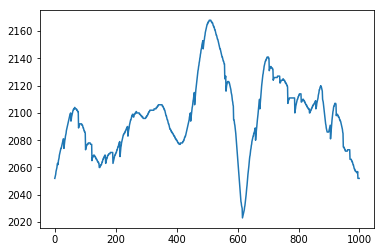

In [53]:
plt.plot(template[0])

In [150]:
plot([go.Scatter(y=bcg_samples)])

'file:///home/guo/Github/BCGHeart/notebook/temp-plot.html'

In [60]:
plot([go.Scatter(y=list(map(lambda p : p[1], templates)))])

'file:///home/guo/Github/BCGHeart/notebook/temp-plot.html'

In [151]:
start = 2626
step = 929
end = 2626 + step #929 #4484 #3555 
template_select = bcg_samples[start:end]
template_select = template_select / l2norm(template_select)
#template_select = (template_select - np.mean(template_select)) / np.std(template_select)

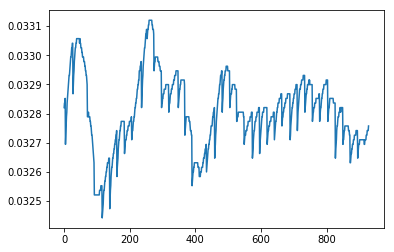

In [152]:
plt.plot(template_select)

In [153]:
bcg_convolved = []
template_length = step#929
for i in range(0, len(bcg_samples)-template_length):
    vec = bcg_samples[i:i+template_length]
    #vec = vec / l2norm(vec)
    vec = (vec - np.mean(vec))/np.std(vec)
    bcg_convolved.append(np.dot(vec,template_select))

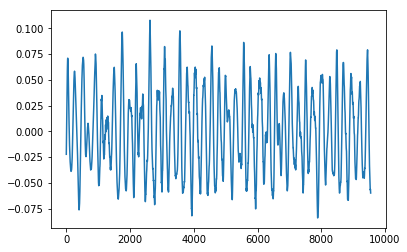

In [146]:
plt.plot(bcg_convolved)

In [155]:
plot([go.Scatter(y=bcg_convolved)])

'file:///home/guo/Github/BCGHeart/notebook/temp-plot.html'

In [96]:
template_select2 = bcg_convolved[3474:4462]
template_select2 = template_select2 / l2norm(template_select2)

In [98]:
bcg_convolved2 = []
template_length = 4462-3474
for i in range(0, len(bcg_convolved)-template_length):
    vec = bcg_convolved[i:i+template_length]
    #vec = vec / l2norm(vec)
    vec = (vec - np.mean(vec))/np.std(vec)
    bcg_convolved2.append(np.dot(vec,template_select2))

In [100]:
plot([go.Scatter(y=bcg_convolved2)])

'file:///home/guo/Github/BCGHeart/notebook/temp-plot.html'

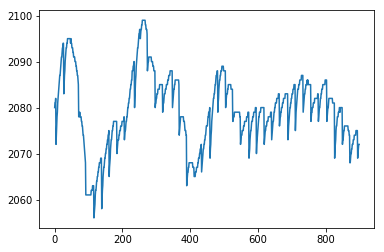

In [139]:
plt.plot(bcg_samples[2626:2626+900])

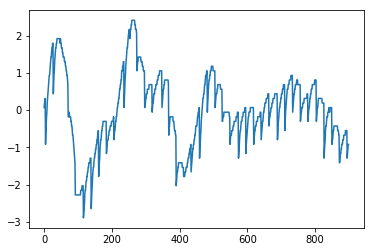

In [141]:
vec = bcg_samples[2626:2626+900]
vec = (vec - np.mean(vec)) / np.std(vec)
plt.plot(vec)

# How to get best template

### find cycle and select it from signal

In [ ]:
def distribution(signal, bin_len=5):
    min = np.min(signal)
    max = np.max(signal)

In [156]:
#fixed n
plot([go.Scatter(y=bcg)])

'file:///home/guo/Github/BCGHeart/notebook/temp-plot.html'

In [ ]:
from scipy.fftpack import fft

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values
t_n = 10
N = 10000
T = 
f_s = 1

f_values, fft_values = get_fft_values(composite_y_value, T, N, f_s)

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

In [159]:

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
 
t_values, autocorr_values = get_autocorr_values(bcg_samples, T, N, 1000)
 
plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')
plt.show()

NameError: name 'composite_y_value' is not defined